# ANA 699 Capstone Project  
## Motorcycle Crash Risk and Injury Severity Analysis

**Team Members:**  
Amber Garcia  
Ed Baek  
Jeremiah Snipes  
Ryan Neighbor  

**Course:** ANA 699A – Analytic Capstone Project I  
**Institution:** National University  

## Project Overview
This notebook supports the ANA 699 capstone project focused on analyzing motorcycle crash data from Southern California. The objective is to explore injury severity patterns, contributing factors, and spatial risk using event-level crash records derived from official California traffic collision data.

At this stage of the capstone, the notebook emphasizes data understanding, exploratory analysis, and methodological planning. Modeling approaches may evolve as the project progresses.


# Boilerplate Packages

In [77]:
# Core
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Deep Learning
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Evaluation & Visualization
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Settings
plt.style.use("ggplot")
sns.set_theme(style="whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

ModuleNotFoundError: No module named 'tensorflow'

# Load and Explore the Data

In [2]:
import pandas as pd

df = pd.read_csv("SoCal_Motorcycle_Crashes.csv", low_memory=False)
df.head()



,CASE_ID,ACCIDENT_YEAR,PROC_DATE,JURIS,COLLISION_DATE,COLLISION_TIME,OFFICER_ID,REPORTING_DISTRICT,DAY_OF_WEEK,CHP_SHIFT,...,COUNT_MC_KILLED,COUNT_MC_INJURED,PRIMARY_RAMP,SECONDARY_RAMP,LATITUDE,LONGITUDE,COUNTY,CITY,POINT_X,POINT_Y
0,81386057,2021,2021-01-12,1942,2021-01-09,1455,30947,0719,6,5,...,0,1,-,-,NaN,NaN,LOS ANGELES,LOS ANGELES,-118.324829,34.076233
1,81386600,2021,2021-01-13,1942,2021-01-11,1440,34959,0813,1,5,...,1,0,-,-,NaN,NaN,LOS ANGELES,LOS ANGELES,-118.468544,34.071571
2,81386739,2021,2021-01-13,1942,2021-01-10,1153,34959,0898,7,5,...,0,1,-,-,NaN,NaN,LOS ANGELES,LOS ANGELES,-118.388931,34.036381
3,81395130,2021,2021-01-27,1942,2021-01-26,1400,38013,NaN,2,5,...,0,1,-,-,NaN,NaN,LOS ANGELES,LOS ANGELES,-118.344032,34.068905
4,81400706,2021,2021-02-02,1942,2021-01-19,1330,37511,2055,2,5,...,0,1,-,-,NaN,NaN,LOS ANGELES,LOS ANGELES,-118.299980,34.049068


### Basic Information

This section provides a high-level overview of the dataset structure, including the number of observations, variables, data types, and the presence of missing values. This step is intended to confirm data integrity and inform later preprocessing decisions.


In [3]:
# Dataset shape
print("Dataset shape (rows, columns):")
df.shape


Dataset shape (rows, columns):


(17322, 80)

In [4]:
# Column names and data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17322 entries, 0 to 17321
Data columns (total 80 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CASE_ID                  17322 non-null  int64  
 1   ACCIDENT_YEAR            17322 non-null  int64  
 2   PROC_DATE                17322 non-null  object 
 3   JURIS                    17322 non-null  int64  
 4   COLLISION_DATE           17322 non-null  object 
 5   COLLISION_TIME           17322 non-null  int64  
 6   OFFICER_ID               17320 non-null  object 
 7   REPORTING_DISTRICT       5537 non-null   object 
 8   DAY_OF_WEEK              17322 non-null  int64  
 9   CHP_SHIFT                17322 non-null  int64  
 10  POPULATION               17322 non-null  int64  
 11  CNTY_CITY_LOC            17322 non-null  int64  
 12  SPECIAL_COND             17322 non-null  int64  
 13  BEAT_TYPE                17322 non-null  int64  
 14  CHP_BEAT_TYPE         

In [5]:
# Summary of missing values
df.isna().sum().sort_values(ascending=False).head(15)


BICYCLE_ACCIDENT       17261
PEDESTRIAN_ACCIDENT    17188
TRUCK_ACCIDENT         17004
CALTRANS_DISTRICT      16868
RAMP_INTERSECTION      16868
ALCOHOL_INVOLVED       16057
CITY_DIVISION_LAPD     16017
ROUTE_SUFFIX           14672
POSTMILE_PREFIX        13868
CALTRANS_COUNTY        12602
POSTMILE               12602
LOCATION_TYPE          12429
REPORTING_DISTRICT     11785
SIDE_OF_HWY            11046
STATE_ROUTE            10713
dtype: int64

Many variables contain missing values because they are conditionally recorded fields. For example, pedestrian, bicycle, and truck indicators are only populated when those crash types are involved. Since this dataset focuses on motorcycle crashes, high levels of missingness in these fields are expected and do not indicate data quality issues. Handling of missing values will be addressed during preprocessing based on analytical needs.


### Visualize the Data

This section provides exploratory visualizations to understand the distribution of key variables related to motorcycle crash outcomes. The goal is to identify broad patterns in injury severity, alcohol involvement, and temporal factors prior to formal modeling.

#### Injury severity distribution

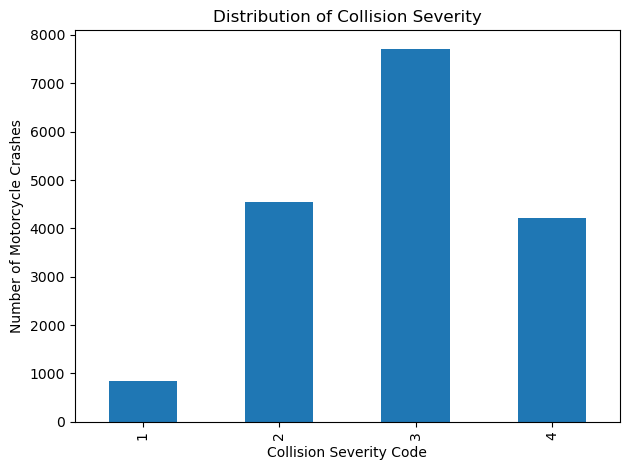

In [7]:
import matplotlib.pyplot as plt

severity_counts = df['COLLISION_SEVERITY'].value_counts().sort_index()

severity_counts.plot(
    kind='bar',
    title='Distribution of Collision Severity',
    xlabel='Collision Severity Code',
    ylabel='Number of Motorcycle Crashes'
)

plt.tight_layout()
plt.show()


#### Alcohol involvement

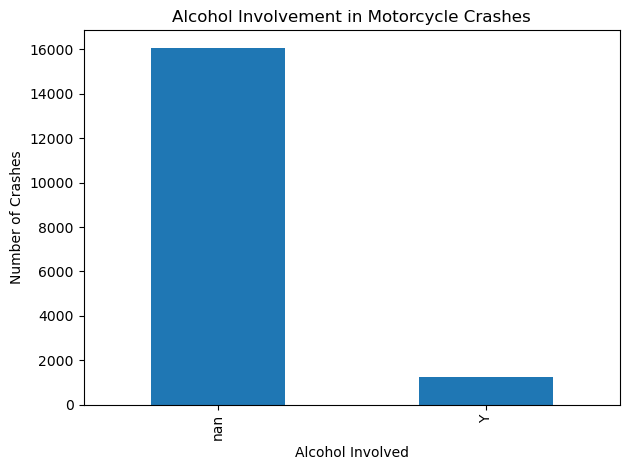

In [8]:
alcohol_counts = df['ALCOHOL_INVOLVED'].value_counts(dropna=False)

alcohol_counts.plot(
    kind='bar',
    title='Alcohol Involvement in Motorcycle Crashes',
    xlabel='Alcohol Involved',
    ylabel='Number of Crashes'
)

plt.tight_layout()
plt.show()


#### Crashes by day of week

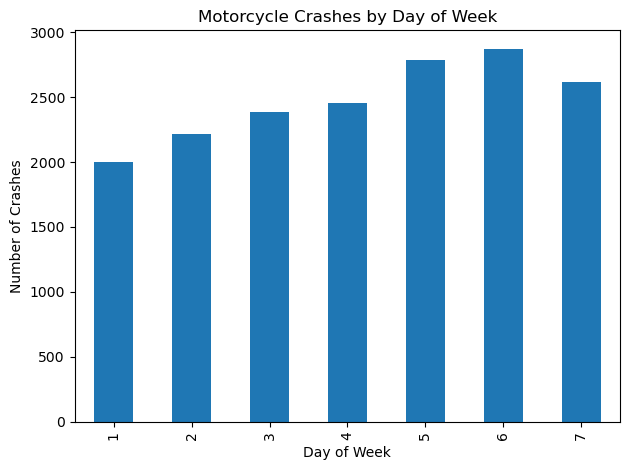

In [9]:
dow_counts = df['DAY_OF_WEEK'].value_counts().sort_index()

dow_counts.plot(
    kind='bar',
    title='Motorcycle Crashes by Day of Week',
    xlabel='Day of Week',
    ylabel='Number of Crashes'
)

plt.tight_layout()
plt.show()


#### Sorting and Filtering

In [33]:
# List of columns to drop
cols_to_drop = [
    # Administrative / IDs
    "CASE_ID",
    "OFFICER_ID",
    "REPORTING_DISTRICT",
    "JURIS",
    "BEAT_TYPE",
    "CHP_BEAT_TYPE",
    "CHP_BEAT_CLASS",
    "BEAT_NUMBER",
    "CITY_DIVISION_LAPD",

    # Non-motorcycle specific accident types
    "PEDESTRIAN_ACCIDENT",
    "BICYCLE_ACCIDENT",
    "TRUCK_ACCIDENT",
    "COUNT_PED_KILLED",
    "COUNT_PED_INJURED",
    "COUNT_BICYCLIST_KILLED",
    "COUNT_BICYCLIST_INJURED",

    # Sparse roadway metadata / postmile details
    "ROUTE_SUFFIX",
    "POSTMILE_PREFIX",
    "POSTMILE",
    "RAMP_INTERSECTION",
    "PRIMARY_RAMP",
    "SECONDARY_RAMP",

    # GIS redundancy
    "POINT_X",
    "POINT_Y",
    "CALTRANS_DISTRICT",
    "CALTRANS_COUNTY",
    "LOCATION_TYPE",
    "DIRECTION", 
    "SIDE_OF_HWY"
]

# Drop columns
df_reduced = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Quick check
print(f"Original columns: {df.shape[1]}")
print(f"Reduced columns: {df_reduced.shape[1]}")

Original columns: 81
Reduced columns: 52
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17322 entries, 0 to 17321
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ACCIDENT_YEAR          17322 non-null  int64         
 1   PROC_DATE              17322 non-null  object        
 2   COLLISION_DATE         17322 non-null  object        
 3   COLLISION_TIME         17322 non-null  int64         
 4   DAY_OF_WEEK            17322 non-null  int64         
 5   CHP_SHIFT              17322 non-null  int64         
 6   POPULATION             17322 non-null  int64         
 7   CNTY_CITY_LOC          17322 non-null  int64         
 8   SPECIAL_COND           17322 non-null  int64         
 9   PRIMARY_RD             17322 non-null  object        
 10  SECONDARY_RD           17322 non-null  object        
 11  DISTANCE               17322 non-null  float64       
 12  INTERSECTION       

In [13]:
# Summary of missing values
df_reduced.isna().sum().sort_values(ascending=False).head(15)

ALCOHOL_INVOLVED        16057
STATE_ROUTE             10713
PCF_VIOL_SUBSECTION     10283
LONGITUDE                5597
LATITUDE                 5597
PCF_VIOLATION             872
CHP_VEHTYPE_AT_FAULT      358
TOW_AWAY                  135
STATE_HWY_IND              10
COUNT_MC_KILLED             0
CHP_ROAD_TYPE               0
MVIW                        0
PED_ACTION                  0
ROAD_SURFACE                0
ROAD_COND_1                 0
dtype: int64

In [15]:
# Missing implies no alcohol involvement
df_reduced["ALCOHOL_INVOLVED"] = (
    df_reduced["ALCOHOL_INVOLVED"]
    .fillna("No")
    .str.strip()
)

In [16]:
# Missing means violation not specified
df_reduced["PCF_VIOLATION"] = (
    df_reduced["PCF_VIOLATION"]
    .fillna("Unknown")
    .astype(str)
)


In [17]:
# Minor missingness, treat as unknown
df_reduced["CHP_VEHTYPE_AT_FAULT"] = (
    df_reduced["CHP_VEHTYPE_AT_FAULT"]
    .fillna("Unknown")
    .str.strip()
)

In [18]:
# Near-complete, missing treated as unknown
df_reduced["TOW_AWAY"] = (
    df_reduced["TOW_AWAY"]
    .fillna("Unknown")
    .str.strip()
)

In [19]:
# Quick verification
df_reduced[[
    "ALCOHOL_INVOLVED",
    "PCF_VIOLATION",
    "CHP_VEHTYPE_AT_FAULT",
    "TOW_AWAY"
]].isna().sum()

ALCOHOL_INVOLVED        0
PCF_VIOLATION           0
CHP_VEHTYPE_AT_FAULT    0
TOW_AWAY                0
dtype: int64

In [23]:
# Missingness summary

missing = df_reduced.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_tbl = (
    pd.DataFrame({"missing_n": missing, "missing_pct": missing_pct})
      .query("missing_n > 0")
      .sort_values("missing_n", ascending=False)
)
display(missing_tbl)

# Duplicate checks

print("Duplicate rows:", df.duplicated().sum())


,missing_n,missing_pct
STATE_ROUTE,10713,61.85
PCF_VIOL_SUBSECTION,10283,59.36
LATITUDE,5597,32.31
LONGITUDE,5597,32.31
STATE_HWY_IND,10,0.06


Duplicate rows: 0


In [28]:
# Target distribution (severity)

if "COLLISION_SEVERITY" in df_reduced.columns:
    sev_counts = df_reduced["COLLISION_SEVERITY"].value_counts(dropna=False)
    sev_pct = (sev_counts / len(df_reduced) * 100).round(2)
    display(pd.DataFrame({"count": sev_counts, "pct": sev_pct}))

# High-cardinality categorical scan

cat_cols = df_reduced.select_dtypes(include=["object"]).columns.tolist()
cardinality = pd.DataFrame({
    "n_unique": df_reduced[cat_cols].nunique(dropna=True),
    "example_values": [df_reduced[c].dropna().unique()[:5] for c in cat_cols]
}).sort_values("n_unique", ascending=False)

display(cardinality.head(25))


# Top categories for key predictors

for col in [c for c in ["PRIMARY_COLL_FACTOR", "TYPE_OF_COLLISION", "LIGHTING", "ROAD_SURFACE", "WEATHER_1", "HIT_AND_RUN"] if c in df_reduced.columns]:
    print("\n", col)
    display(df_reduced[col].value_counts(dropna=False).head(15))


# Simple severity vs feature crosstabs

def severity_crosstab(feature, top_n=10):
    if "COLLISION_SEVERITY" not in df_reduced.columns or feature not in df_reduced.columns:
        return
    
    top_levels = df_reduced[feature].value_counts().head(top_n).index
    tmp = df_reduced[df_reduced[feature].isin(top_levels)]
    ct = pd.crosstab(tmp[feature], tmp["COLLISION_SEVERITY"], normalize="index").round(3)
    display(ct)

for feature in [c for c in ["ALCOHOL_INVOLVED", "HIT_AND_RUN", "LIGHTING", "WEATHER_1", "ROAD_SURFACE", "TYPE_OF_COLLISION"] if c in df_reduced.columns]:
    print(f"\nSeverity distribution by {feature} (top levels):")
    severity_crosstab(feature, top_n=10)


# Correlation on numeric fields

num_df = df_reduced.select_dtypes(include=[np.number])
corr = num_df.corr(numeric_only=True)

# Show strongest correlations (excluding self)
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
)
display(corr_pairs.head(20))

,count,pct
COLLISION_SEVERITY,,
3,7709,44.50
2,4541,26.22
4,4221,24.37
1,851,4.91


,n_unique,example_values
SECONDARY_RD,9363,"[BEVERLY BL, GUNSTON DRIVE, OLIN STREET, 5700 ..."
PRIMARY_RD,5801,"[N LUCERNE BL, SUNSET BOULEVARD, ROBERTSON BOU..."
COLLISION_DATE,1094,"[2021-01-09, 2021-01-11, 2021-01-10, 2021-01-2..."
PROC_DATE,1002,"[2021-01-12, 2021-01-13, 2021-01-27, 2021-02-0..."
CITY,151,"[LOS ANGELES, INGLEWOOD, GARDENA, MONTEREY PAR..."
PCF_VIOLATION,111,"[21802.0, 21650.0, 21658.0, 21801.0, 21663.0]"
CHP_VEHTYPE_AT_FAULT,39,"[01, 02, 99, 22, 03]"
PCF_VIOL_CATEGORY,31,"[09, 05, 07, 17, 03]"
MVIW,18,"[C, I, E, D, J]"
STWD_VEHTYPE_AT_FAULT,15,"[A, C, -, D, F]"



 PRIMARY_COLL_FACTOR


PRIMARY_COLL_FACTOR
A    16486
D      402
C      287
B       94
-       53
Name: count, dtype: int64


 TYPE_OF_COLLISION


TYPE_OF_COLLISION
D    4331
B    3583
C    3243
F    2649
E    1724
A     810
H     745
G     139
-      98
Name: count, dtype: int64


 LIGHTING


LIGHTING
A    11872
C     3609
D     1111
B      655
-       42
E       33
Name: count, dtype: int64


 ROAD_SURFACE


ROAD_SURFACE
A    16844
B      329
-       88
D       53
C        7
H        1
Name: count, dtype: int64


 WEATHER_1


WEATHER_1
A    15824
B     1255
C      122
-       72
E       23
G       17
F        6
D        3
Name: count, dtype: int64


 HIT_AND_RUN


HIT_AND_RUN
N    15397
F     1548
M      377
Name: count, dtype: int64


Severity distribution by ALCOHOL_INVOLVED (top levels):


COLLISION_SEVERITY,1,2,3,4
ALCOHOL_INVOLVED,,,,
No,0.041,0.259,0.449,0.252
Y,0.158,0.305,0.394,0.143



Severity distribution by HIT_AND_RUN (top levels):


COLLISION_SEVERITY,1,2,3,4
HIT_AND_RUN,,,,
F,0.033,0.253,0.477,0.238
M,0.011,0.082,0.451,0.456
N,0.052,0.268,0.442,0.239



Severity distribution by LIGHTING (top levels):


COLLISION_SEVERITY,1,2,3,4
LIGHTING,,,,
-,0.000,0.167,0.524,0.310
A,0.035,0.244,0.466,0.255
B,0.060,0.270,0.412,0.258
C,0.077,0.300,0.391,0.232
D,0.096,0.329,0.421,0.154
E,0.152,0.394,0.242,0.212



Severity distribution by WEATHER_1 (top levels):


COLLISION_SEVERITY,1,2,3,4
WEATHER_1,,,,
-,0.056,0.153,0.444,0.347
A,0.049,0.265,0.445,0.241
B,0.052,0.229,0.451,0.269
C,0.066,0.189,0.418,0.328
D,0.000,0.333,0.667,0.000
E,0.087,0.609,0.174,0.130
F,0.000,0.333,0.333,0.333
G,0.000,0.412,0.471,0.118



Severity distribution by ROAD_SURFACE (top levels):


COLLISION_SEVERITY,1,2,3,4
ROAD_SURFACE,,,,
-,0.000,0.284,0.386,0.330
A,0.049,0.263,0.446,0.242
B,0.064,0.204,0.422,0.310
C,0.000,0.286,0.429,0.286
D,0.019,0.245,0.509,0.226
H,0.000,0.000,0.000,1.000



Severity distribution by TYPE_OF_COLLISION (top levels):


COLLISION_SEVERITY,1,2,3,4
TYPE_OF_COLLISION,,,,
-,0.020,0.265,0.449,0.265
A,0.067,0.396,0.328,0.209
B,0.017,0.182,0.484,0.317
C,0.040,0.233,0.428,0.299
D,0.074,0.336,0.361,0.229
E,0.104,0.294,0.444,0.159
F,0.029,0.250,0.555,0.166
G,0.115,0.266,0.410,0.209
H,0.017,0.169,0.564,0.250


NUMBER_KILLED         COUNT_MC_KILLED         0.971815
CNTY_CITY_LOC         LONGITUDE               0.850356
COLLISION_SEVERITY    COUNT_COMPLAINT_PAIN    0.594731
NUMBER_INJURED        COUNT_MC_INJURED        0.542635
                      COUNT_COMPLAINT_PAIN    0.399721
                      COUNT_VISIBLE_INJ       0.284560
COUNT_VISIBLE_INJ     COUNT_MC_INJURED        0.245707
COLLISION_SEVERITY    COUNT_MC_INJURED        0.221249
NUMBER_INJURED        COUNT_SEVERE_INJ        0.189927
                      PARTY_COUNT             0.188585
DISTANCE              LONGITUDE               0.176609
POPULATION            DISTANCE                0.173189
COUNT_SEVERE_INJ      COUNT_MC_INJURED        0.163252
COLLISION_TIME        CHP_SHIFT               0.158887
PARTY_COUNT           COUNT_COMPLAINT_PAIN    0.156549
CHP_SHIFT             LATITUDE                0.130986
POPULATION            LONGITUDE               0.121857
COLLISION_SEVERITY    NUMBER_INJURED          0.116737
POPULATION

In [34]:
# Create binary severity outcome
severe_codes = [1, 2]

df_reduced["SEVERE_INJURY"] = df_reduced["COLLISION_SEVERITY"].isin(severe_codes).astype(int)

# Check balance
sev_counts = df_reduced["SEVERE_INJURY"].value_counts()
sev_pct = (sev_counts / len(df_reduced) * 100).round(2)

print(pd.DataFrame({"count": sev_counts, "percent": sev_pct}))

               count  percent
SEVERE_INJURY                
0              11930    68.87
1               5392    31.13


In [37]:
# Ensure datetime
df_reduced["COLLISION_DATE_DT"] = pd.to_datetime(
    df_reduced["COLLISION_DATE"], errors="coerce"
)

# Hour derived
t = df_reduced["COLLISION_TIME"].astype(str).str.zfill(4)
df_reduced["COLLISION_HOUR"] = pd.to_numeric(t.str[:2], errors="coerce")

# Weekend indicator
df_reduced["IS_WEEKEND"] = df_reduced["DAY_OF_WEEK"].isin([1, 7]).astype(int)

# Month
df_reduced["COLLISION_MONTH"] = df_reduced["COLLISION_DATE_DT"].dt.month


In [44]:
#severity stratified EDA
def severity_summary(feature, top_n=10):
    tmp = df_reduced.copy()
    
    if tmp[feature].nunique() > top_n:
        top_levels = tmp[feature].value_counts().head(top_n).index
        tmp = tmp[tmp[feature].isin(top_levels)]
    
    summary = (
        tmp.groupby(feature)["SEVERE_INJURY"]
        .agg(["mean", "count"])
        .rename(columns={"mean": "severe_rate"})
    )
    
    summary["severe_rate"] = (summary["severe_rate"] * 100).round(2)
    return summary.sort_values("severe_rate", ascending=False)




In [45]:
severity_summary("ALCOHOL_INVOLVED")

,severe_rate,count
ALCOHOL_INVOLVED,,
Y,46.32,1265


In [46]:
severity_summary("LIGHTING")

,severe_rate,count
LIGHTING,,
E,54.55,33
D,42.48,1111
C,37.77,3609
B,32.98,655
A,27.93,11872
-,16.67,42


In [47]:
severity_summary("WEATHER_1")

,severe_rate,count
WEATHER_1,,
E,69.57,23
G,41.18,17
D,33.33,3
F,33.33,6
A,31.40,15824
B,28.05,1255
C,25.41,122
-,20.83,72


In [48]:
severity_summary("TYPE_OF_COLLISION", top_n=8)

,severe_rate,count
TYPE_OF_COLLISION,,
A,46.30,810
D,40.98,4331
E,39.73,1724
G,38.13,139
F,27.86,2649
C,27.32,3243
B,19.90,3583
H,18.66,745


In [49]:
severity_summary("HIT_AND_RUN")

,severe_rate,count
HIT_AND_RUN,,
N,31.92,15397
F,28.55,1548
M,9.28,377


In [50]:
severity_summary("CHP_ROAD_TYPE")
severity_summary("STATE_HWY_IND")

,severe_rate,count
STATE_HWY_IND,,
N,33.43,10035
Y,27.96,7277


In [51]:
# Severity by hour
hourly = (
    df_reduced.groupby("COLLISION_HOUR")["SEVERE_INJURY"]
    .mean()
    .mul(100)
    .round(2)
)

hourly


COLLISION_HOUR
0     42.18
1     41.23
2     52.72
3     43.82
4     35.66
5     32.75
6     23.70
7     24.08
8     22.22
9     30.49
10    29.59
11    29.68
12    29.68
13    28.98
14    28.96
15    25.48
16    27.37
17    28.61
18    32.93
19    35.28
20    40.88
21    39.78
22    44.02
23    42.42
25    48.15
Name: SEVERE_INJURY, dtype: float64

In [52]:
# Severity by weekend
df_reduced.groupby("IS_WEEKEND")["SEVERE_INJURY"].mean().mul(100).round(2)


IS_WEEKEND
0    30.01
1    34.20
Name: SEVERE_INJURY, dtype: float64

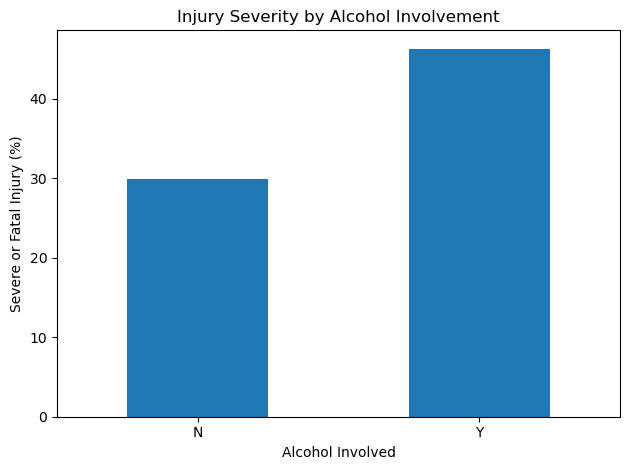

In [63]:
# Visualization building for Presentation

df_reduced["ALCOHOL_CLEAN"] = (
    df_reduced["ALCOHOL_INVOLVED"]
    .fillna("N")
    .str.upper()
    .replace({
        "NO": "N",
        "YES": "Y"
    })
)


alcohol_rates = (
    df_reduced.groupby("ALCOHOL_CLEAN")["SEVERE_INJURY"]
    .mean()
    .mul(100)
)

alcohol_rates.plot(kind="bar")
plt.ylabel("Severe or Fatal Injury (%)")
plt.xlabel("Alcohol Involved")
plt.title("Injury Severity by Alcohol Involvement")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


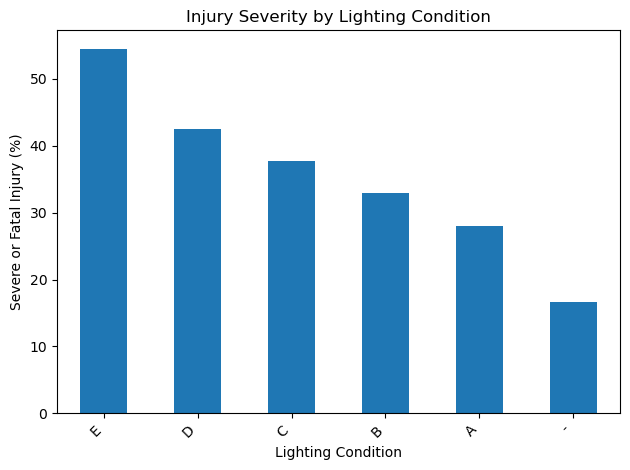

In [54]:
lighting_rates = (
    df_reduced.groupby("LIGHTING")["SEVERE_INJURY"]
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

lighting_rates.plot(kind="bar")
plt.ylabel("Severe or Fatal Injury (%)")
plt.xlabel("Lighting Condition")
plt.title("Injury Severity by Lighting Condition")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


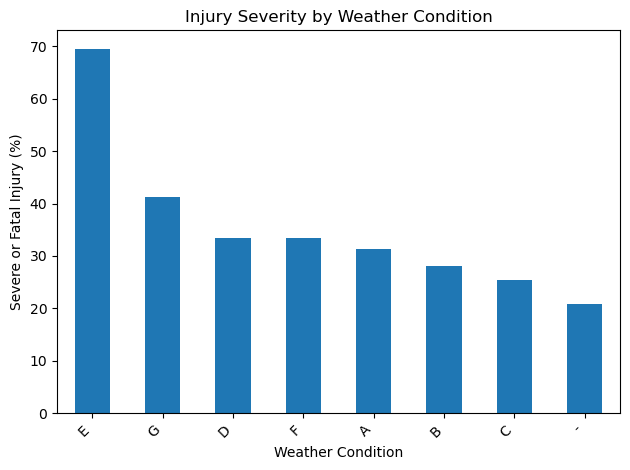

In [55]:
weather_rates = (
    df_reduced.groupby("WEATHER_1")["SEVERE_INJURY"]
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

weather_rates.plot(kind="bar")
plt.ylabel("Severe or Fatal Injury (%)")
plt.xlabel("Weather Condition")
plt.title("Injury Severity by Weather Condition")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


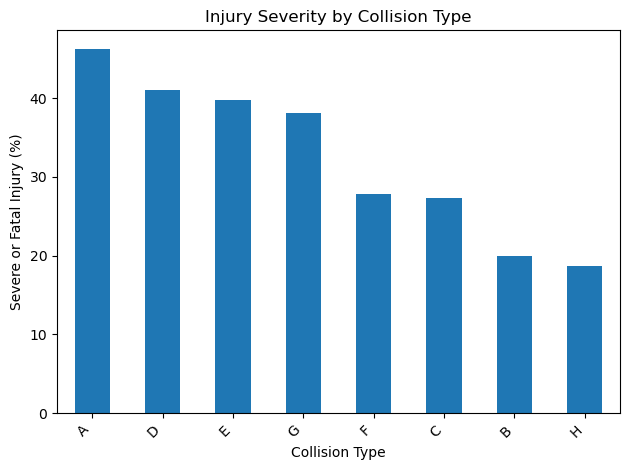

In [56]:
top_collision_types = (
    df_reduced["TYPE_OF_COLLISION"]
    .value_counts()
    .head(8)
    .index
)

collision_rates = (
    df_reduced[df_reduced["TYPE_OF_COLLISION"].isin(top_collision_types)]
    .groupby("TYPE_OF_COLLISION")["SEVERE_INJURY"]
    .mean()
    .mul(100)
    .sort_values(ascending=False)
)

collision_rates.plot(kind="bar")
plt.ylabel("Severe or Fatal Injury (%)")
plt.xlabel("Collision Type")
plt.title("Injury Severity by Collision Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


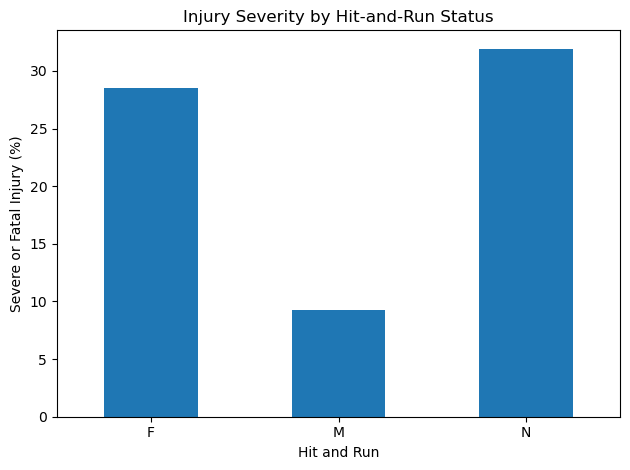

In [57]:
hitrun_rates = (
    df_reduced.groupby("HIT_AND_RUN")["SEVERE_INJURY"]
    .mean()
    .mul(100)
)

hitrun_rates.plot(kind="bar")
plt.ylabel("Severe or Fatal Injury (%)")
plt.xlabel("Hit and Run")
plt.title("Injury Severity by Hit-and-Run Status")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


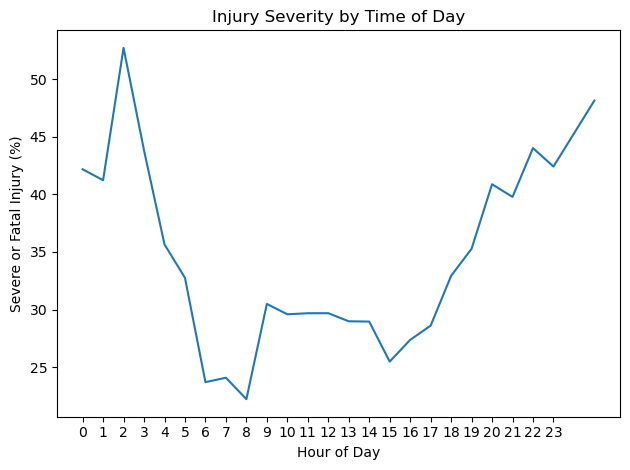

In [58]:
hourly_rates = (
    df_reduced.groupby("COLLISION_HOUR")["SEVERE_INJURY"]
    .mean()
    .mul(100)
)

hourly_rates.plot()
plt.ylabel("Severe or Fatal Injury (%)")
plt.xlabel("Hour of Day")
plt.title("Injury Severity by Time of Day")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


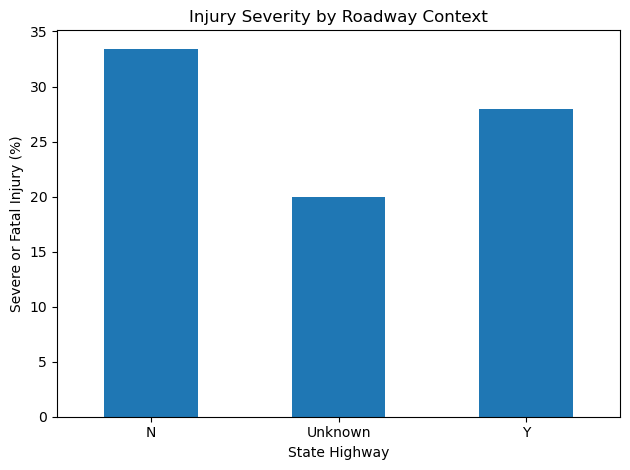

In [64]:
df_reduced["ROADWAY_CONTEXT"] = df_reduced["STATE_HWY_IND"].fillna("Unknown")


roadway_rates = (
    df_reduced.groupby("ROADWAY_CONTEXT")["SEVERE_INJURY"]
    .mean()
    .mul(100)
)

roadway_rates.plot(kind="bar")
plt.ylabel("Severe or Fatal Injury (%)")
plt.xlabel("State Highway")
plt.title("Injury Severity by Roadway Context")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Logistic Regression

model_df = df_reduced[[
    "SEVERE_INJURY",     
    "ALCOHOL_CLEAN",
    "LIGHTING",
    "WEATHER_1",
    "TYPE_OF_COLLISION",
    "HIT_AND_RUN",
    "STATE_HWY_IND",
    "COLLISION_HOUR",
    "IS_WEEKEND"
]].copy()

In [73]:
model_df = model_df.dropna()

In [74]:
X = pd.get_dummies(
    model_df.drop(columns="SEVERE_INJURY"),
    drop_first=True
)

y = model_df["SEVERE_INJURY"]

print(X.shape, y.shape)

(17312, 26) (17312,)


In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

logit = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear"
)

logit.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [82]:
y_pred = logit.predict(X_test)
y_prob = logit.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

ROC AUC: 0.6416877117584014
              precision    recall  f1-score   support

           0       0.78      0.60      0.68      3577
           1       0.41      0.63      0.50      1617

    accuracy                           0.61      5194
   macro avg       0.60      0.61      0.59      5194
weighted avg       0.67      0.61      0.62      5194



In [83]:
# Odds Ratio
coef_df = pd.DataFrame({
    "variable": X.columns,
    "coef": logit.coef_[0]
})

coef_df["odds_ratio"] = np.exp(coef_df["coef"])

coef_df = coef_df.sort_values("odds_ratio", ascending=False)

coef_df.head(15)

,variable,coef,odds_ratio
12,WEATHER_1_E,1.260121,3.525849
7,LIGHTING_E,0.873203,2.394567
6,LIGHTING_D,0.739483,2.094852
15,TYPE_OF_COLLISION_A,0.590214,1.804374
2,ALCOHOL_CLEAN_Y,0.573888,1.775156
5,LIGHTING_C,0.455313,1.576667
18,TYPE_OF_COLLISION_D,0.417827,1.518657
11,WEATHER_1_D,0.416967,1.517353
13,WEATHER_1_F,0.416929,1.517295
14,WEATHER_1_G,0.396873,1.487167


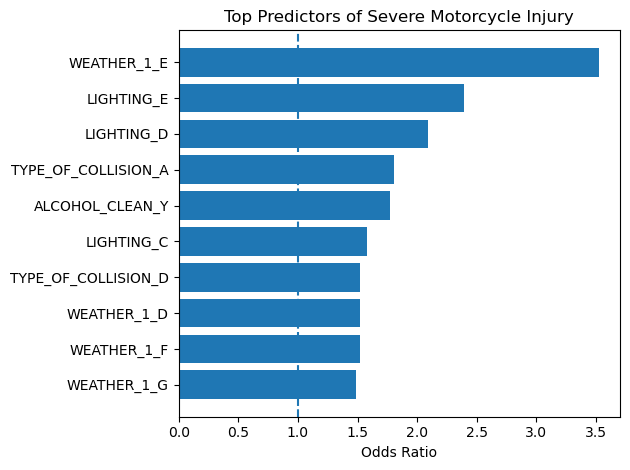

In [84]:
# Odds Visualized
top_vars = coef_df.head(10)

plt.barh(top_vars["variable"], top_vars["odds_ratio"])
plt.axvline(1, linestyle="--")
plt.xlabel("Odds Ratio")
plt.title("Top Predictors of Severe Motorcycle Injury")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Split the Data for Training and Testing

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

##### Interpretation

# Model | Artificial Neural Network (ANN) | Train | Tune | Evaluation


#### Build the Model

##### Interpretation

#### Train the Model

##### Interpretation

#### Tune the Model

##### Interpretation

#### Evaluate the Model


# Model | Artificial Neural Network (ANN) | Train | Tune | Evaluation

#### Build the Model

##### Interpretation

#### Train the Model

##### Interpretation

#### Tune the Model

##### Interpretation

#### Evaluate the Model


##### Interpretation

# Compare the two models | ANN | CNN

# References  

Scikit-learn Developers. (2024). *Scikit-learn: Machine learning in Python (Version 1.5.0)* [Computer software].  
https://scikit-learn.org/stable/  

Matplotlib Development Team. (2024). *Matplotlib: Visualization with Python* [Computer software].  
https://matplotlib.org/  

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … Duchesnay, É. (2011). *Scikit-learn: Machine Learning in Python.* *Journal of Machine Learning Research, 12*, 2825–2830.  
https://www.jmlr.org/papers/v12/pedregosa11a.html  

Python Software Foundation. (2024). *Python (Version 3.12)* [Computer software].  
https://www.python.org/  

NumPy Developers. (2024). *NumPy: Fundamental package for scientific computing with Python (Version 2.0)* [Computer software].  
https://numpy.org/  

TensorFlow Developers. (2024). *Keras: Sequential model and convolutional layers.* Retrieved from
https://www.tensorflow.org/guide/keras/sequential_model

TensorFlow Keras Documentation. (2024). *Sequential model and dense layers.* Retrieved from https://www.tensorflow.org/guide/keras/sequential_model

Géron, A. (2022). *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow* (3rd ed.). O’Reilly Media.

# End Project